In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from common import load_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

In [2]:
def plot_cutoff_feasibility(system):
    (
        perf_matrix_initial,
        input_features,
        config_features,
        all_performances,
        input_preprocessor,
        config_preprocessor,
    ) = load_data(system=system, data_dir="../data", input_properties_type="tabular")

    # performances = ["fps", "cpu"]
    # performances = ["kbs", "fps"]
    performances = []

    if len(performances) == 0:
        performances = all_performances

    records = []

    for num_p in range(1, len(all_performances)+1):
        performances = all_performances[:num_p]
        # Normalization is needed for the Pareto cutoff
        # We can normalize before splitting, because
        # we normalize per input and we also split per input.
        # There is no data leakage.
        normalized_metrics = (
            perf_matrix_initial[["inputname"] + performances]
            .groupby("inputname", as_index=False)
            .transform(lambda x: (x - x.min()) / (x.max() - x.min()))
        )

        nmdf = (
            perf_matrix_initial[["inputname"] + performances]
            .groupby("inputname", as_index=True)
            .transform(lambda x: (x - x.min()) / (x.max() - x.min()))
        )
        perf_matrix = pd.merge(
            perf_matrix_initial, nmdf, suffixes=("_raw", None), left_index=True, right_index=True
        )
        # perf_matrix["feasible"] = cutoff_mask

        for cutoff in range(1, 11):
            # All metrics of a single measurement must be below the cutoff
            perf_matrix["feasible"] = (normalized_metrics <= cutoff/10).all(axis=1)
            # Does an input have any feasible measurement?
            aggdf = perf_matrix[["inputname", "feasible"]].groupby(["inputname"]).any() 
            # How many inputs have at least one feasible measurement?
            feasible_inputs = aggdf.sum()
            records.append((num_p, cutoff/10, feasible_inputs.item()))

    df = pd.DataFrame.from_records(records, columns=["num_p", "cutoff", "feasible"])

    plt.figure()
    fig = (
        ggplot(df, mapping=aes(x="cutoff", y="feasible"))
        + geom_line()
        + facet_wrap("num_p")
        + xlab("Pareto Cutoff")
        + ylab("#Inputs with Feasible Measurement")
        + ggtitle(system)
    )
    fig.show()

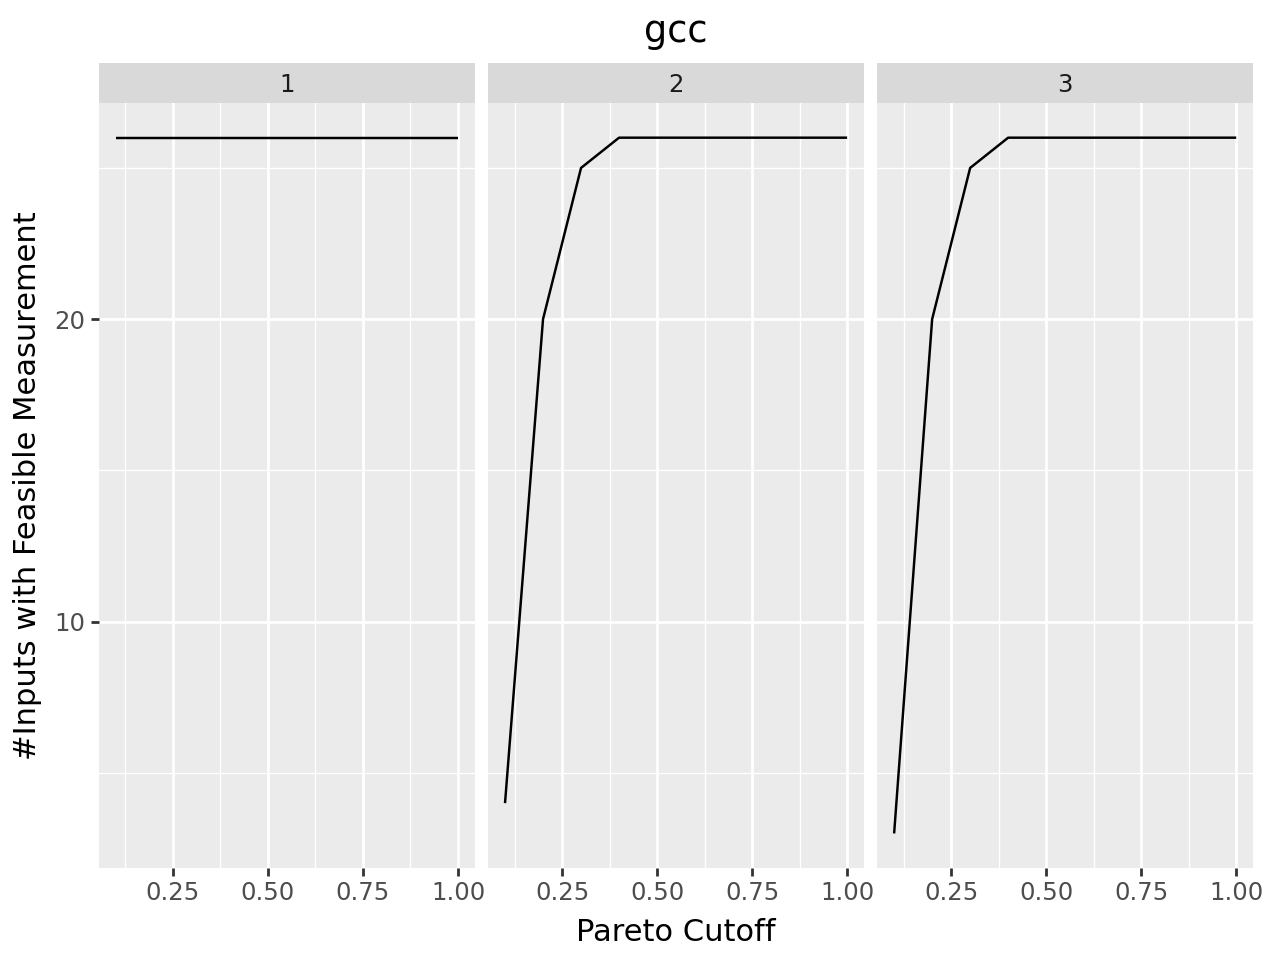

<Figure size 640x480 with 0 Axes>

In [3]:
plot_cutoff_feasibility("gcc")

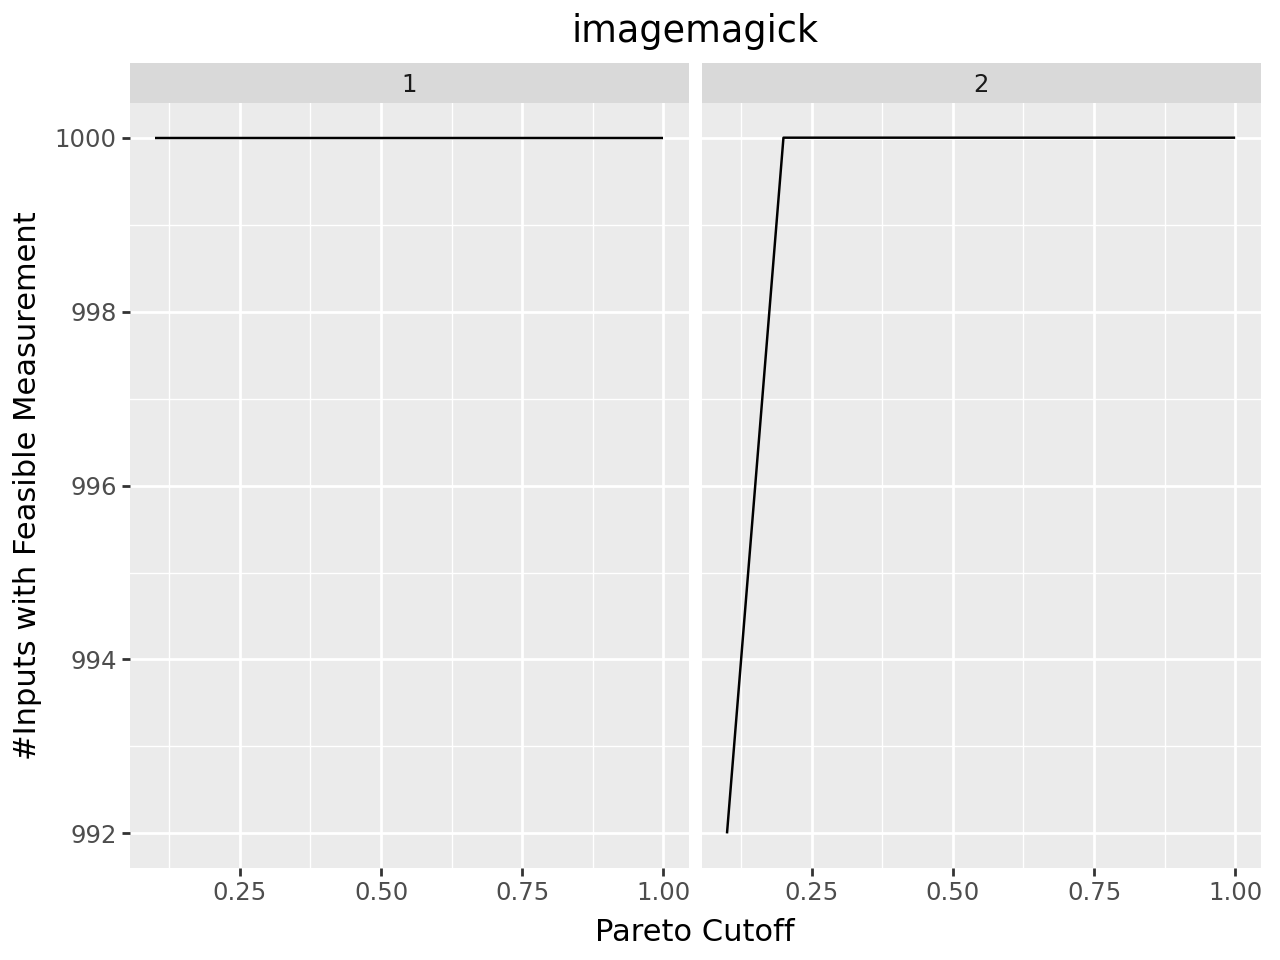

<Figure size 640x480 with 0 Axes>

In [4]:
plot_cutoff_feasibility("imagemagick")

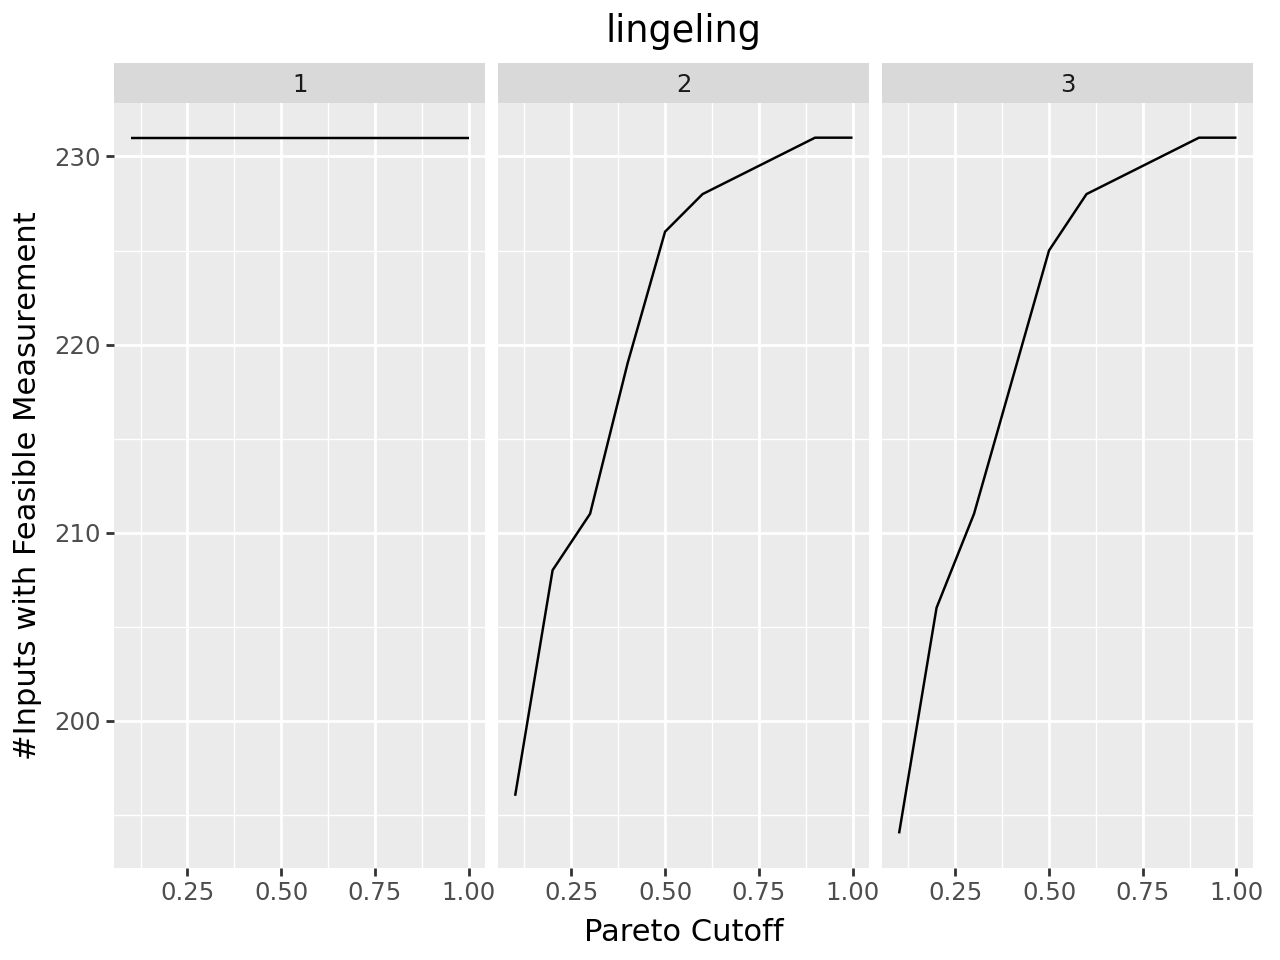

<Figure size 640x480 with 0 Axes>

In [5]:
plot_cutoff_feasibility("lingeling")

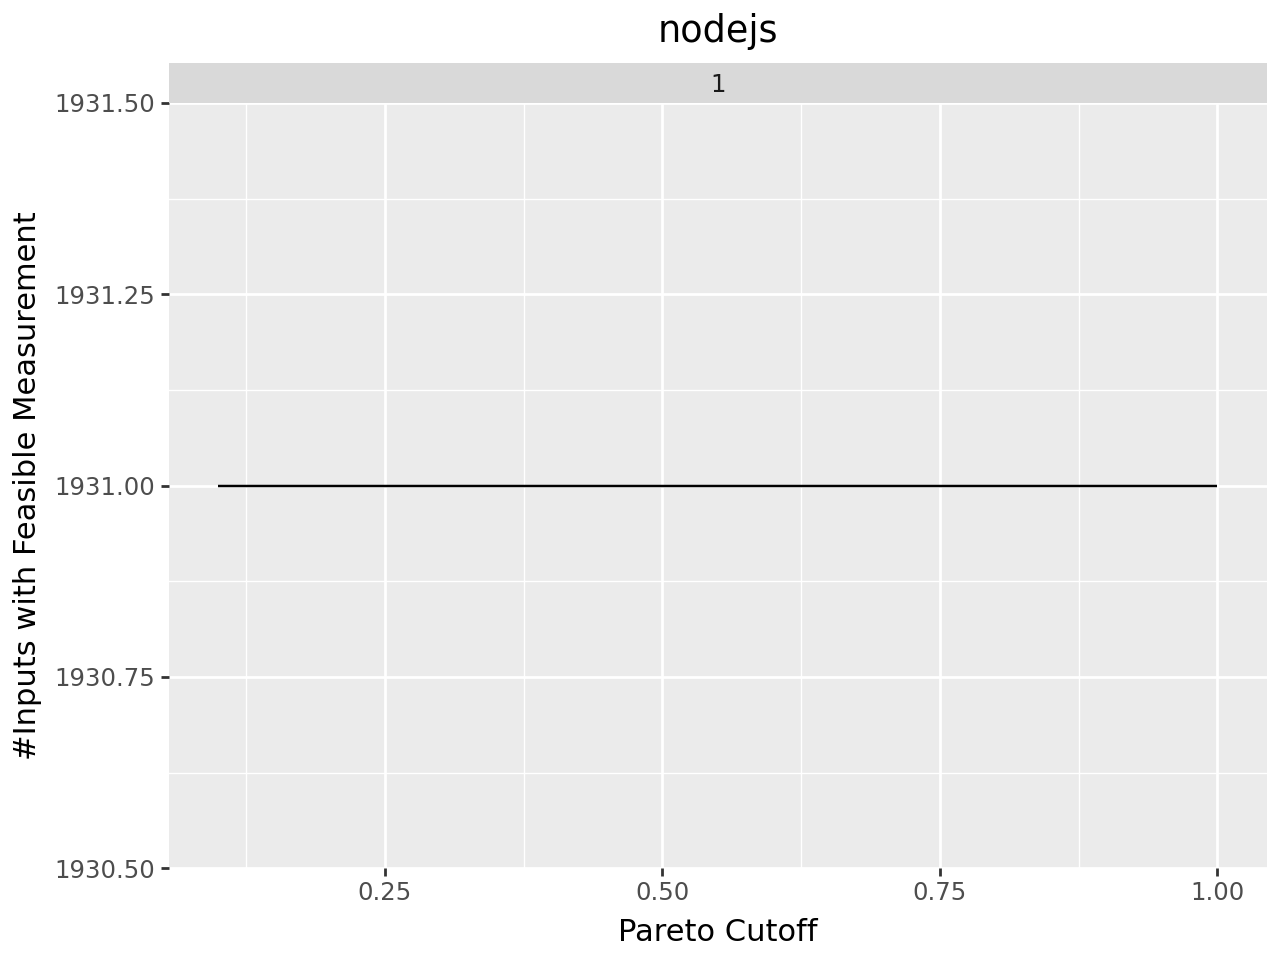

<Figure size 640x480 with 0 Axes>

In [6]:
plot_cutoff_feasibility("nodejs")

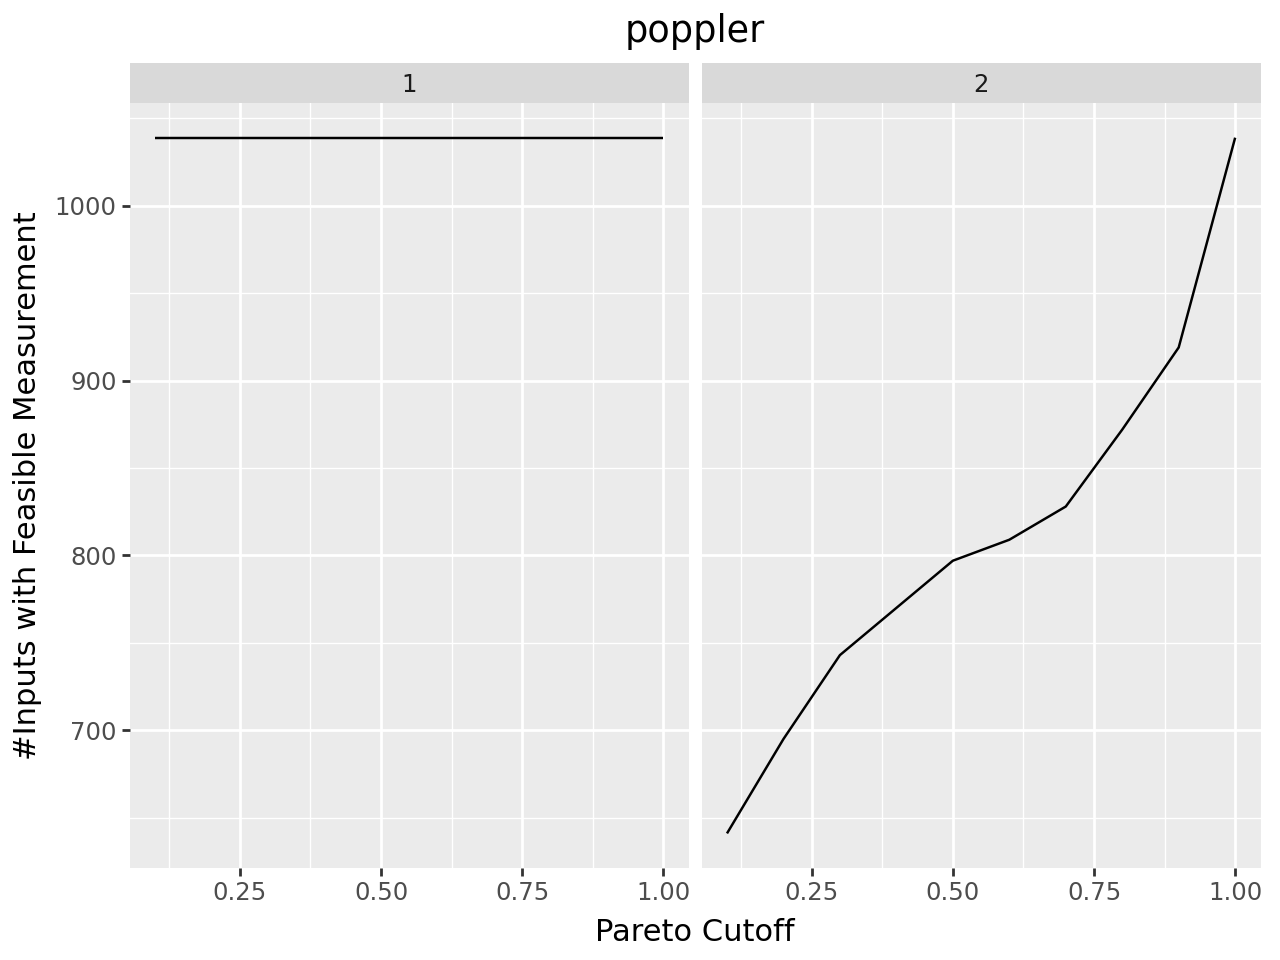

<Figure size 640x480 with 0 Axes>

In [7]:
plot_cutoff_feasibility("poppler")

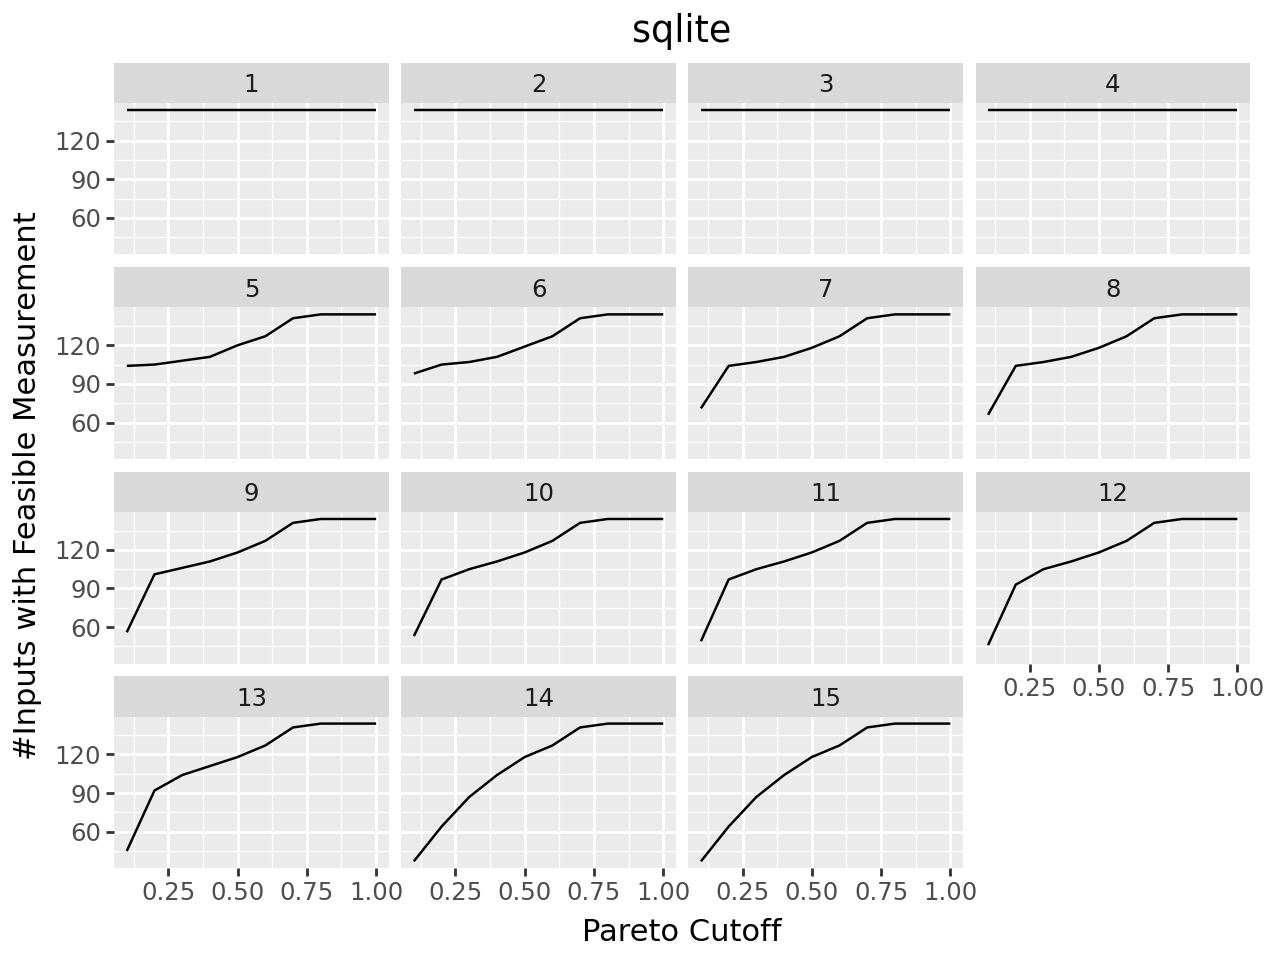

<Figure size 640x480 with 0 Axes>

In [8]:
plot_cutoff_feasibility("sqlite")

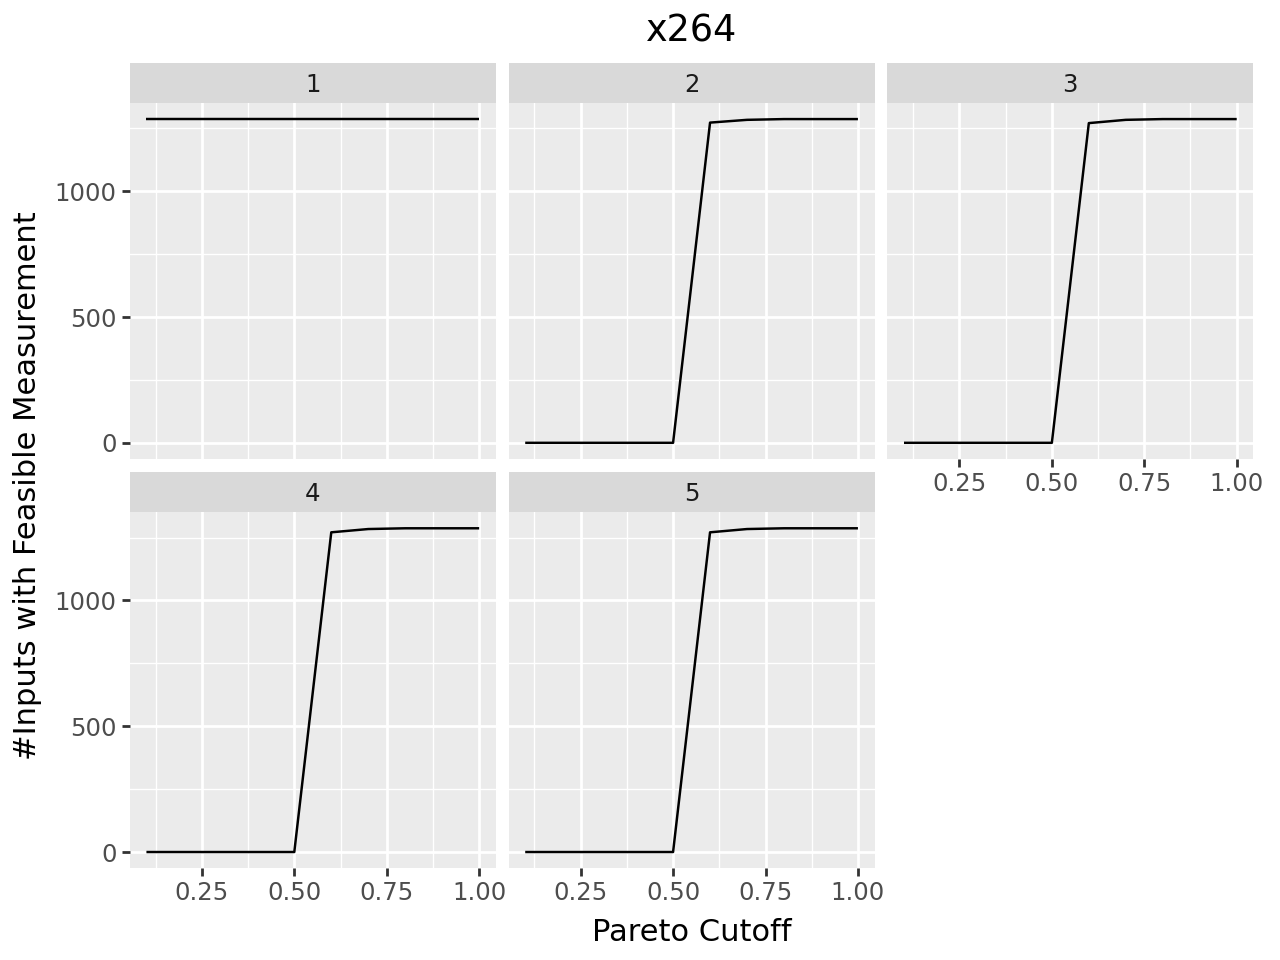

<Figure size 640x480 with 0 Axes>

In [9]:
plot_cutoff_feasibility("x264")

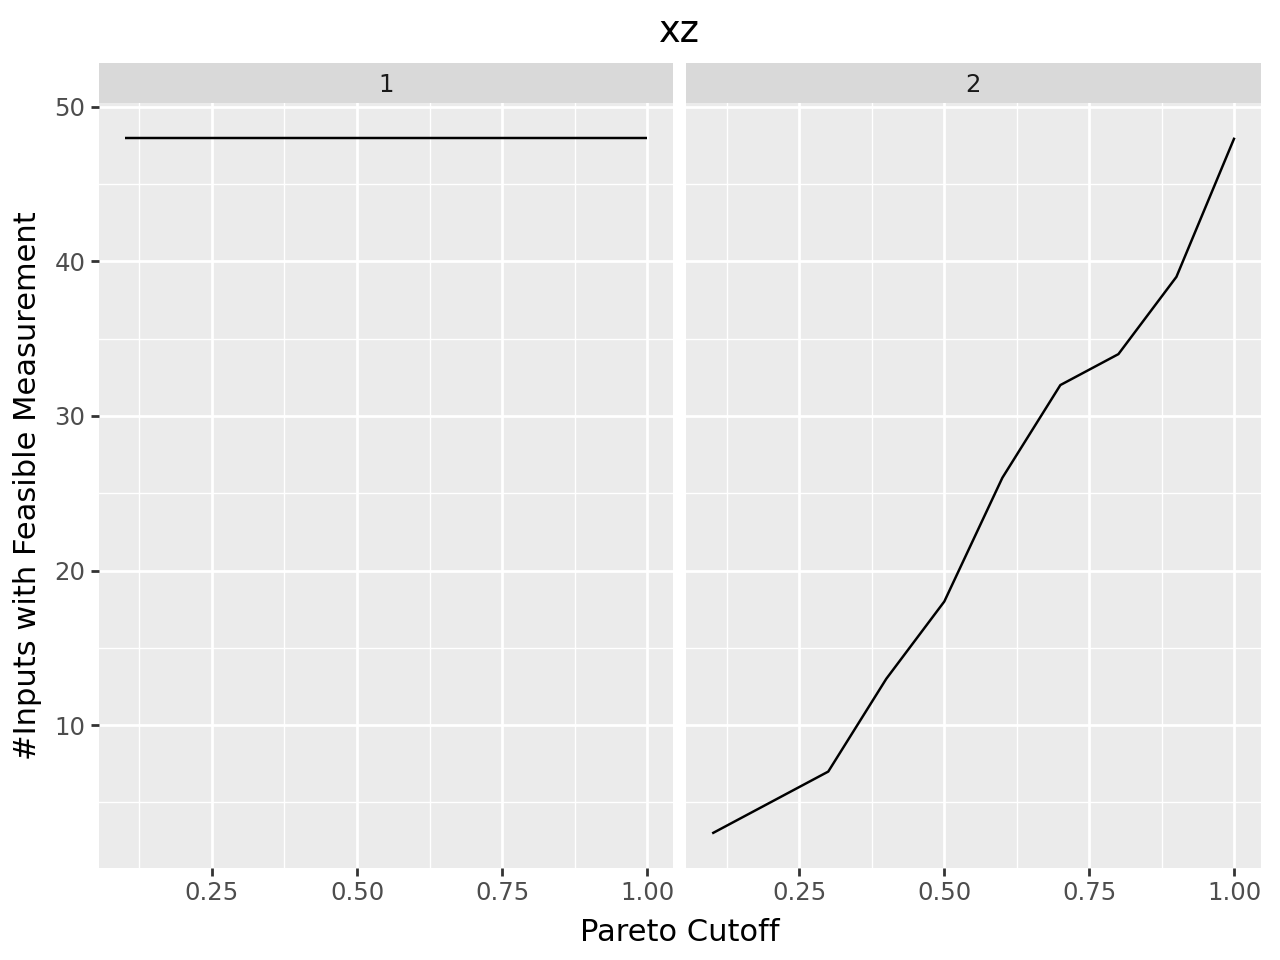

<Figure size 640x480 with 0 Axes>

In [10]:
plot_cutoff_feasibility("xz")